In [3]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tclab
import time

In [4]:
dt = 10
Ad = np.array([ [0.91192162, 0.04164008, 0.,         0.       ],
                [0.04174326, 0.91254068, 0.,         0.       ],
                [0.25748892, 0.00609829, 0.7297587,  0.       ],
                [0.0061134,  0.25757959, 0.,         0.7297587]])

Bd = np.array([ [4.56191496e-02, 6.52373931e-04],
                [1.02831049e-03, 2.90228102e-02],
                [6.58171477e-03, 6.43735510e-05],
                [1.01469410e-04, 4.18683129e-03]])

[nx, nu] = Bd.shape

# Setpoints
T1_sp  = 305
T2_sp  = 303
TC1_sp = T1_sp
TC2_sp = T2_sp
Q1_sp  = 10.479084076952502
Q2_sp  = 6.348721315236462

In [9]:
lab = tclab.TCLab()
T1_0 = lab.T1 + 273.15
T2_0 = lab.T2 + 273.15
lab.close()

TCLab version 0.4.9


AlreadyConnectedError: You already have an open connection

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
TCLab disconnected successfully.
TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
0 [-5.41 -3.51 -5.41 -3.51]
10 [-5.47 -3.41 -5.47 -3.48]
20 [-5.15 -3.54 -5.15 -3.54]
30 [-4.51 -3.19 -4.51 -3.12]
40 [-3.77 -2.45 -3.77 -2.51]
50 [-2.89 -2.12 -2.89 -2.16]
60 [-2.15 -1.51 -2.15 -1.51]
70 [-1.54 -1.22 -1.48 -1.28]
80 [-0.96 -0.8  -0.96 -0.87]
90 [-0.32 -0.48 -0.32 -0.61]
100 [ 0.01 -0.22  0.01 -0.32]
110 [ 0.33 -0.03  0.33  0.  ]
120 [0.36 0.   0.36 0.  ]
130 [0.62 0.   0.62 0.  ]
140 [0.65 0.04 0.65 0.  ]
150 [0.65 0.   0.59 0.04]
160 [0.33 0.   0.33 0.  ]
170 [0.33 0.   0.3  0.  ]
180 [0.2  0.   0.07 0.  ]
190 [0.04 0.07 0.01 0.07]
200 [ 0.01 -0.19  0.01 -0.19]
210 [-0.12 -0.32 -0.12 -0.22]
220 [-0.28 -0.32 -0.28 -0.32]
230 [-0.32 -0.22 -0.32 -0.32]
240 [-0.28 -0.32 -0.32 -0.22]
250 [-0.32 -0.32 -0.25 -0.22]
260 [-0.22 -0.32 -0.

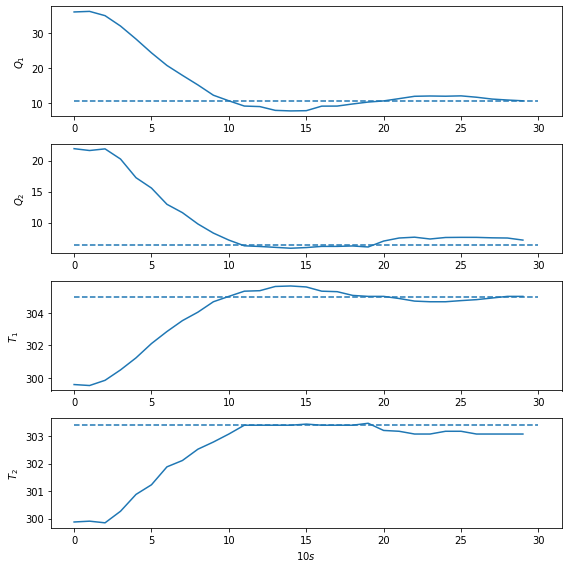

In [ ]:
# Constraints
umin = np.array([0, 0])     - np.array([Q1_sp, Q2_sp])
umax = np.array([100, 100]) - np.array([Q1_sp, Q2_sp])

# Objective function
Q  = 20*np.eye(nx)
QN = Q
R  = np.eye(nu)

# Initial and reference states
lab = tclab.TCLab()
T1_0 = lab.T1 + 273.15
T2_0 = lab.T2 + 273.15
lab.close()

x0 = np.array([T1_0, T2_0, T1_0, T2_0]) - np.array([T1_sp, T2_sp, TC1_sp, TC2_sp])

# Prediction horizon
N = 12

# Define problem
u      = cp.Variable((nu, N))
x      = cp.Variable((nx, N+1))
x_init = cp.Parameter(nx)

objective   = cp.quad_form(x[:,N], QN)
constraints = [x[:, 0] == x_init]
for k in range(N):
    objective   += cp.quad_form(x[:,k], Q) + cp.quad_form(u[:,k], R)
    constraints += [x[:,k+1] == Ad@x[:,k] + Bd@u[:,k]]
    constraints += [umin <= u[:,k], u[:,k] <= umax]
prob = cp.Problem(cp.Minimize(objective), constraints)

# Simulate in closed loop
nsim = 30
u1_use = []
u2_use = []
x1_use = []
x2_use = []

lab = tclab.TCLab()
for i in range(nsim):
    print(i*dt, x0)
    x_init.value = x0
    prob.solve()
    lab.Q1(u.value[0,0].tolist() + Q1_sp)
    lab.Q2(u.value[0,0].tolist() + Q2_sp)

    u1_use.append(u.value[0,0].tolist())
    u2_use.append(u.value[1,0].tolist())
    x1_use.append(x.value[2,0].tolist())
    x2_use.append(x.value[3,0].tolist())
    time.sleep(dt)
    x0 = np.array([lab.T1, lab.T2, lab.T1, lab.T2]) + 273.15 - np.array([T1_sp, T2_sp, TC1_sp, TC2_sp])
lab.close()

u1_use = np.array(u1_use) + Q1_sp
u2_use = np.array(u2_use) + Q2_sp
x1_use = np.array(x1_use) + TC1_sp
x2_use = np.array(x2_use) + TC2_sp

# Plot
f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(411)

plt.plot(u1_use)
plt.hlines(y=Q1_sp, xmin=0, xmax=nsim, linestyles='dashed')
plt.ylabel(r"$Q_1$")

plt.subplot(4, 1, 2)
plt.plot(u2_use)
plt.hlines(y=Q2_sp, xmin=0, xmax=nsim, linestyles='dashed')
plt.ylabel(r"$Q_2$")

plt.subplot(4, 1, 3)
plt.plot(x1_use)
plt.hlines(y=TC1_sp, xmin=0, xmax=nsim, linestyles='dashed')
plt.ylabel(r"$T_1$")

plt.subplot(4, 1, 4)
plt.plot(x2_use)
plt.hlines(y=TC2_sp, xmin=0, xmax=nsim, linestyles='dashed')
plt.ylabel(r"$T_2$")

plt.xlabel(r"$10s$")
plt.tight_layout()
plt.show()